# Project 1

In [235]:
# Import the dependencies
import time

import matplotlib.pyplot as plt
import cv2 as cv
from math import atan, degrees
from numba import jit
from numpy import argmin, argmax, array, empty, exp, ma, ndarray, nonzero, histogram, random, round
# from pandas import DataFrame
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score, completeness_score, accuracy_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from tslearn.clustering import KernelKMeans

In [26]:
# Set true for the final version to deliver!
final = False

In [2]:
# Some help functions
def log(msg):
    t = time.localtime()
    curr_time = time.strftime("%H:%M:%S", t)
    print(curr_time, msg)


# Give the homogeneity, completeness & accuracy score for the given labeling
def scores(true_labels, labels):
    hom = homogeneity_score(true_labels, labels)
    com = completeness_score(true_labels, labels)
    acc = accuracy_score(true_labels, labels)
    
    return hom, com, acc


# Visualize the given centroids
def showCentroids(c):
    print('Centroids:')
    plt.figure(figsize=(20, 10))
    if isinstance(c, DataFrame):
        c = c.to_numpy()
    for i, x in enumerate(c):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x.reshape(28, 28))
        plt.axis('off')
    plt.show()


# Show 10x zero, 10x one, ..., 10x nine
def show10(X, y):
    K = 10

    # For each digit 0, ..., 9, retrieve 10 samples
    plt.figure(figsize=(10, 10))
    n = 1
    for k in range(K):
        Xk = X.loc[y == k].sample(K)
        for i, x in Xk.iterrows():
            plt.subplot(10, 10, n)
            plt.imshow(x.values.reshape(28, 28))
            plt.axis('off')
            n += 1
    plt.show()

In [3]:
# Load the data
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, cache=True)
print('The data are loaded')

In [52]:
# For testing: Split the data set into a smaller training (& validation) set
if final:
    X_train = X
    y_train = y
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.99)
log("Let us train using " + str(len(X_train)) + " samples.")

# Remove the original indices & scale X
X_train = X_train.reset_index(drop=True) / 255
y_train = y_train.astype('int').reset_index(drop=True)

# Just to get an impression of the data contents (labels)
print('Frequency per label:\n', y_train.value_counts())

# Convert the data to arrays
# X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

09:55:47 Let us train using 700 samples.
Frequency per label:
 1    79
7    73
3    71
2    70
9    70
0    69
6    69
4    68
8    68
5    63
Name: class, dtype: int64


## Exercise 1a

In [233]:
# @jit(nopython=True, parallel=True)
def kMeans(X, y_true, K: int, metric: str):
    log('Starting K-means clustering using the metric \'%s\'' % metric)
    
    # Randomly initialize the centroids c
    N, M = X.shape
    if isinstance(X, ndarray):
        c = X[random.randint(N, size=K)]
    else:
        c = X.sample(K).reset_index(drop=True)
    y = [-1] * N  # Labels

    ePrev = M * N + 1
    eNew = ePrev - 1
    while ePrev - eNew > 0:
        ePrev = eNew
        eNew = 0

        # Assign x_i to cluster k = argmin_j || x_i - c_j ||
        if isinstance(X, ndarray):
            for i, x in enumerate(X):
                if metric == 'gauss':
                    gamma = .001
                    dists = cdist([x], c, 'sqeuclidean')
                    dists = exp(-gamma * dists)
                else:
                    dists = cdist([x], c, metric)
                y[i] = argmin(dists)

            # Update the centroid positions
            for k in range(K):
                Ck = X[[i for i, yi in enumerate(y) if yi == k]]  # Compute Ck = {x_i where the label y_i = k}
                if len(Ck) > 0:
                    c[k] = Ck.mean()                            # Centroid = the mean of the elements in Ck
                    eNew += cdist([c[k]], Ck).sum()             # Compute the error
                else:
                    # Try to find a good position for this centroid
                    c[k] = c.mean()
        else:
            for i, x in X.iterrows():
                if metric == 'gauss':
                    gamma = .001
                    dists = cdist([x.array], c, 'sqeuclidean')
                    dists = exp(-gamma * dists)
                else:
                    dists = cdist([x.array], c, metric)
                y[i] = argmin(dists)

            # Update the centroid positions
            for k in range(K):
                Ck = X.loc[[i for i, yi in enumerate(y) if yi == k]]  # Compute Ck = {x_i where the label y_i = k}
                if len(Ck) > 0:
                    c.loc[k] = Ck.mean()                            # Centroid = the mean of the elements in Ck
                    eNew += cdist([c.loc[k]], Ck).sum()             # Compute the error
                else:
                    # Try to find a good position for this centroid
                    c.loc[k] = c.mean()
    
    # Determine the accuracy
    a = 0
    for k in range(K):
        Lk = y_true[[i for i, yi in enumerate(y) if yi == k]]  # Lk = {y_true_i : y_i = k}
        Lk = DataFrame(data=Lk)
        cnt = Lk.value_counts()
        cnt = cnt.values
        if len(cnt) > 0:
            a += cnt[0]
    a /= N
    
#     showCentroids(c)

    return y, a  # Return the labels

In [242]:
def doCluster(X, y, show=True):
    K = 10
    
    def A(kmeans):
        c = kmeans.cluster_centers_
        y_found = kmeans.labels_
        s = 0
        for k in range(K):
            df = DataFrame(data=y[y_found == k])
            cnt = df.value_counts()
            s += cnt.values[0]
        return s / len(X)
    
    
    # Apply the K-means clustering algorithm using the square Euclidean distance measure
    start = time.time()
#     XX = X.to_numpy
    myLabels, a1 = kMeans(X, y, K, 'sqeuclidean')
    t1 = time.time() - start
    myScore = scores(y, myLabels)
    
    # Use correlation as distance measure
    start = time.time()
    myLabels2, a2 = kMeans(X, y, K, 'correlation')
    t2 = time.time() - start
    myScore2 = scores(y, myLabels2)
    
    # Use the Gaussian distance measure
    start = time.time()
    myLabels3, a3 = kMeans(X, y, K, 'gauss')
    t3 = time.time() - start
    myScore3 = scores(y, myLabels3)

    # Use an existing algorithm
    start = time.time()
#     kmeans = KMeans(n_clusters=K, random_state=1).fit(X)
    kmeans = KMeans(n_clusters=K, init='k-means++').fit(X)  # Slight speedup
    t = time.time() - start
    score = scores(y, kmeans.labels_)
    
    # Print the results
    log('Results:\nAlgorithm \tHomogeneity Completeness   Accuracy   Time [s]\n'
        'My K-Means \t%11.4f %12.4f %10.1f%% %9.3f' % (myScore[0], myScore[1], a1*100, t1) +
        '\nMy K-Means corr.%11.4f %12.4f %10.1f%% %9.3f' % (myScore2[0], myScore2[1], a2*100, t2) +
        '\nMy K-Means gauss.%10.4f %12.4f %10.1f%% %9.3f' % (myScore3[0], myScore3[1], a3*100, t3) +
        '\nExist. K-Means\t%11.4f %12.4f %10.1f%% %9.3f' % (score[0], score[1], A(kmeans)*100, t))
    
    if show:
        showCentroids(kmeans.cluster_centers_)

09:56:26 Starting K-means clustering using the metric 'sqeuclidean'
09:56:28 Starting K-means clustering using the metric 'correlation'
09:56:33 Starting K-means clustering using the metric 'gauss'
09:56:35 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.4907       0.5073       56.6%     2.138
My K-Means corr.     0.5771       0.5789       64.3%     4.854
My K-Means gauss.    0.1854       0.3074       27.1%     0.257
Exist. K-Means	     0.5280       0.5475       61.3%     1.329
Centroids:


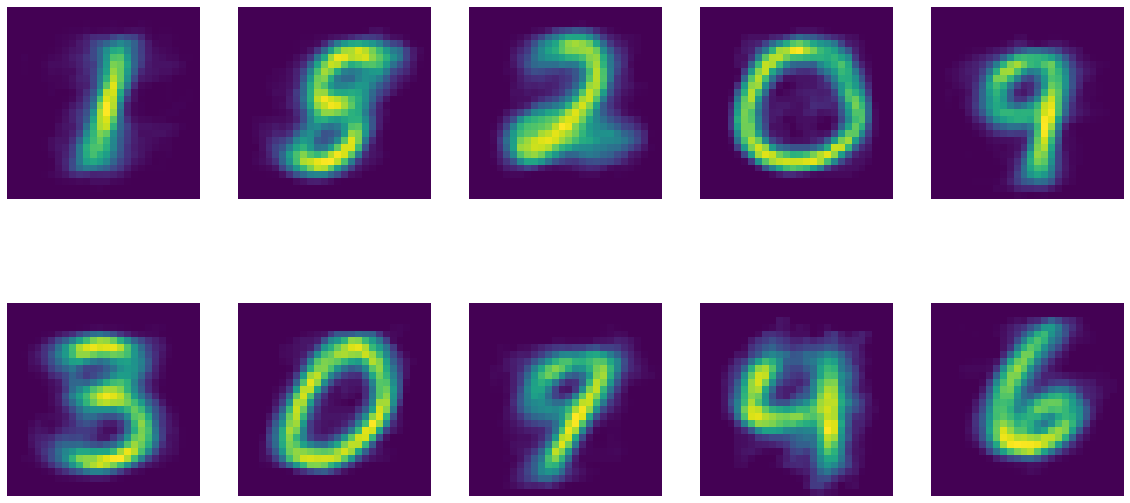

In [56]:
doCluster(X_train, y_train)

## Exercise 1b
Let $\phi$ be a function that transforms the original image vector $x$ to $\phi(x)$. Then the kernel would be $K(x_1, x_2) = \phi(x)^T \phi(x)$.
In the following code, we implement a function $\phi$ which consists of several image processing steps.
These are:
* Blurring;
* Equalization;
* Rotation correction.

**Blurring**: In order to account for small inaccuracies/noise (or speckles, etc.) in the written digit, we use a small Gaussian blurring function.
The Gaussian function in 2D is defined as
$$
G(x,y) = \frac{1}{2\pi \sigma^2} \exp\left( -\frac{x^2 - y^2}{2\sigma^2} \right),
$$
where $x$ and $y$ define the distance from the center pixel.

A socalled (discrete) Gaussian kernel (or convolution matrix) $K_G$ of size $3\times 3$ is equal to $(K_G)_{x,y} = cG(x,y)$, where $c$ is a constant such that the elements of $K_G$ sum to 1.

In [178]:
k = cv.getGaussianKernel(3, 0)  # Get the 1D Gaussian kernel
print('1D:', k)
print('2D:', k @ k.T)                  # Print the 2D Gaussian kernel

1D: [[0.25]
 [0.5 ]
 [0.25]]
2D: [[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


The library OpenCV has a function called $\texttt{GaussianBlur}$ to apply this kernel as filtering (convolution) operation. Given that $\texttt{sigmaX = 0}$ is parsed to this function, $\texttt{GaussianBlur}$ computes the variance $\sigma^2$ derived from the size of $K_G$.

**Equalization**:
Some digits are written very light and some heavy (bold). In order to make these differences smaller, (histogram) equalization is applied.
Suppose that an image is given with values in the range 0 to 255 (uint8), having a maximum pixel value of 100. Then equalization creates a mapping $h$ from each current pixel value $v$ to a new pixel value $h(v)$, making e.g. 100 255. This mapping $h$ is as follows.
$$
{\displaystyle h(v)=\mathrm {round} \left({\frac {\operatorname {cdf} (v)-\operatorname {cdf} _{\min }}{(M\times N)-\operatorname {cdf} _{\min }}}\times (L-1)\right)}
$$
where cdf$_{\text{min}}$ is the minimum non-zero value of the cumulative distribution function (in this case 1), $M\times N$ gives the image's number of pixels and $L$ is the number of grey levels used.
cdf$(v)$ denotes the cumulative distribution function of the pixel value $v$.

In [179]:
# Equalize the histogram
def equalize(img):
    hist, bins = histogram(img.flatten(),256,[0,256])
    cdf = hist.cumsum()
    cdf_m = ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = ma.filled(cdf_m,0).astype('uint8')
    
    return cdf[img]

**Rotation Correction**:
Our image rotation correction function comprises a rotation detection step, giving the rotation angle, which is used to rotate the image over that angle.

*Rotation Detection*:
In order to make an approximation of the rotation of the written digit, firstly, we compute the average index of the non-zero pixels per row.
Then we fit a line through these points, using a linear least squares (LLS).

Let the linear approximation be $f_{a,b}(x) = a + bx$. Let the residual for vector $i$ be $r_i(a,b) = y_i - f_{a,b}(x_i), i = 1,...,|X|$.
LLS minimizes the sum $S(a,b) = \sum_{i = 1}^{|X|} r_i^2(a,b)$.
The optimal values for $a$ and $b$ can be found by solving $\frac{\partial S}{\partial a} = \frac{\partial S}{\partial b} = 0$.

In [ ]:
# Given a set of points with coordinates (x,y) in X x Y, find the best line fit y = a + b * x & return a, b.
# Based on code from https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
def fitLine(X, Y):
    xbar = sum(X) / len(X)
    ybar = sum(Y) / len(Y)
    n = len(X)

    numer = sum([xi * yi for xi, yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

#     print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))
    
    return a, b

Given the slope $b$, the rotation angle is atan$(b)$ rad. Hence the correction rotation angle is -atan$(b)$ rad.

*Rotation Correction*:
In order to rotate the image over the given angle, we compute a rotation matrix. Say that a rotation of angle $\theta$ is done of a $2\times 2$ image, the rotation matrix $R_\theta$ is as follows.
$$
{\displaystyle R_\theta = {\begin{bmatrix}\cos \theta &-\sin \theta \\\sin \theta &\cos \theta \end{bmatrix}}}
$$
Given the input image vector $x$, the rotated image is $x' = R_\theta x$.
This can be generalized for larger input and output vectors.
The resulting vector $x'$ is the original image $x$, rotated over angle $\theta$.

Why is rotating the image useful? Suppose we have two written ones, where the one is exactly vertically aligned and the other has a slope of 30 degrees. Then the Euclidean distance between the corresponding image vectors might be large and as a result, the ones may belong to different clusters after applying the K-means clustering algorithm. Using the rotation correction function, we try to prevent this.

In [123]:
# Rotate the given image by [angle] degrees
# Inspired by https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate(img, angle):
#     print('rotate {:.2f} deg'.format(angle))
    img_center = tuple(array(img.shape[1::-1]) / 2)
    rot_mat = cv.getRotationMatrix2D(img_center, angle, 1.0)
    return cv.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv.INTER_LINEAR)


# Detect & correct the rotation of the written digit
def correctRotation(img):
    nz = nonzero(img)                       # Find the mean index of the nonzeros per row
    df = DataFrame(data=nz)
    means = df.T.groupby(0).mean()
    inds = means.index.to_numpy()           # Make it an ndarray
    _, b = fitLine(inds, means[1].values)   # Fit a line (y = a + b * x) in order to detect the rotation
    return rotate(img, degrees(atan(-b)))   # Rotate the image


# Sharpen the given image
def sharpen(img):
    sharpen_filter = array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    img = cv.filter2D(img, -1, sharpen_filter)
    
    return img


# Define an image processing function. Use r as radius for the Gaussian blurring step
def procImg(img, r):
    img = (255 * img).astype('uint8')      # Convert the image to uint8 to process it
    img = cv.GaussianBlur(img, (r, r), 0)  # Blur
    img = cv.equalizeHist(img)             # Equalize
    # Other tries were the following, though they did not improve the clustering accuracy.
#     img = equalize(img)
#     img = sharpen(img)                     # Sharpen
#     img = setBounds(img)
#     img[img < 80] = 0  # Threshold
#         # img = cv.Canny(img, 30, 150)    # Edge detection
        # Sum each row and put the value in the right most pixel
#         img[:,27] = sum(img, 2)
#         img[27,:] = sum(img, 1)
    img = correctRotation(img)
#     img = correctRotation(img)  # Try a second correction
    
    return img.astype('float32') / 255

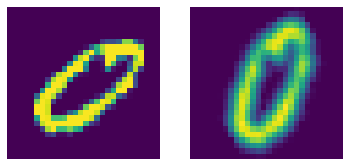

In [180]:
# Test the image processor
img = X_train.loc[10].values.reshape(28, 28)
imgP = procImg(img, 3)

# plt.imshow(img, imgP)
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(imgP)
plt.axis('off')
plt.show;

In [ ]:
# Process the images. Use r as radius for the Gaussian blurring step.
def process(X, r):
    X_proc = X.copy()
    for i, x in X.iterrows():
        
        # Process image x
        img = x.values.reshape(28, 28)
        img = procImg(img, r)
        X_proc.loc[i] = img.reshape(784)
    
    return X_proc

In order to test which value to take as blurring radius r, we do the image processing using this radius and then run the K-means clustering algorithm 3 times per value $r \in [1, 3, 5, 7]$. The resulting average accuracy is logged and shown below. The best radius is picked and used in the next image processing steps.

In [181]:
# Test the performance (resulting accuracy) of applying K-means after a blurring step
K = 10
r_max = 7
r_vals = range(1, r_max + 1, 2)
a = [0] * len(r_vals)            # Accuracy
t = [0] * len(r_vals)            # Processing times
for i in range(len(r_vals)):
    r = r_vals[i]
    print('Test r =', r)
    
    # Process the images using blurring radius r
    t_i = time.time()
    X_proc = process(X_train, r)
    t[i] = time.time() - t_i
    

    # Cluster the processed data using K-Means & record the accuracy (mean over several runs)
    n_acc = 3
    acc = 0
    for j in range(n_acc):
        _, acc_j = kMeans(X_proc, y_train, K, 'sqeuclidean')
        acc += acc_j
    a[i] = acc / n_acc

Test r = 1
13:41:33 Starting K-means clustering using the metric 'sqeuclidean'
13:41:34 Starting K-means clustering using the metric 'sqeuclidean'
13:41:36 Starting K-means clustering using the metric 'sqeuclidean'
Test r = 3
13:41:46 Starting K-means clustering using the metric 'sqeuclidean'
13:41:48 Starting K-means clustering using the metric 'sqeuclidean'
13:41:49 Starting K-means clustering using the metric 'sqeuclidean'
Test r = 5
13:42:02 Starting K-means clustering using the metric 'sqeuclidean'
13:42:03 Starting K-means clustering using the metric 'sqeuclidean'
13:42:05 Starting K-means clustering using the metric 'sqeuclidean'
Test r = 7
13:42:20 Starting K-means clustering using the metric 'sqeuclidean'
13:42:23 Starting K-means clustering using the metric 'sqeuclidean'
13:42:25 Starting K-means clustering using the metric 'sqeuclidean'


700 samples were used.
The average image processing time for this data set was 9.616895616054535 s.


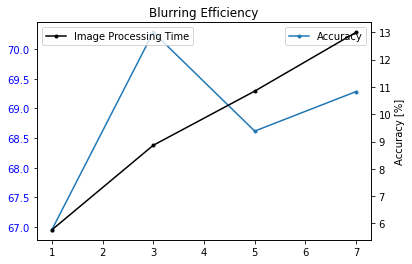

In [198]:
# Plot the results
print(len(X_train), 'samples were used.')
print('The average image processing time for this data set was', array(t).mean(), 's.')
fig, ax = plt.subplots()
# Plot the accuracy
ax.plot(r_vals, 100 * array(a), '.-')
ax.tick_params(axis='y', labelcolor='blue')
ax.legend(['Accuracy'])
# Plot the image processing time
ax2 = ax.twinx()
ax2.plot(r_vals, t, '.-k')
ax2.legend(['Image Processing Time'])
plt.xlabel('Radius r')
plt.ylabel('Accuracy [%]')
plt.title('Blurring Efficiency');

In [205]:
# Select the best radius r
r_best = r_vals[argmax(a)]
print('r_best =', r_best, ', giving an accuracy of {:2.1f} %'.format(100 * max(a)))

r_best = 3 , giving an accuracy of 70.3 %


In [204]:
# Reprocess the data using the best radius r
X_proc = process(X_train, r_best)

r_best = 3 , giving an accuracy of 70.3 %


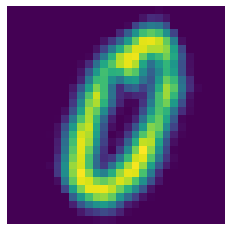

In [167]:
# Test X_proc as the result of process. Is it as expected?
img = X_proc.loc[10].values.reshape(28, 28)
plt.imshow(img)
plt.axis('off')
plt.show;

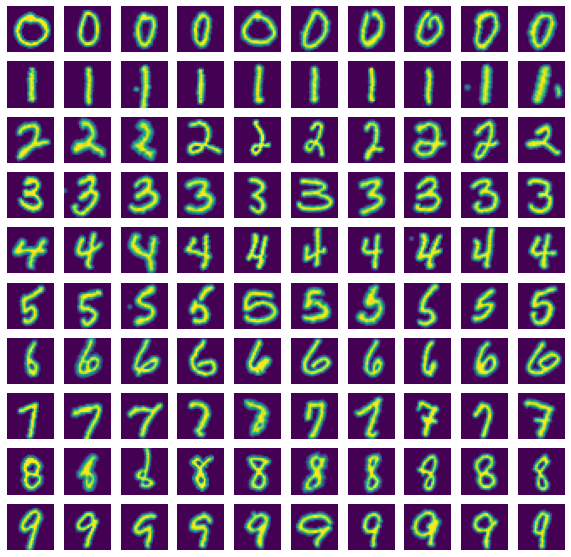

In [89]:
# Show some results
show10(X_proc, y_train)

11:21:25 Starting K-means clustering using the metric 'sqeuclidean'
11:21:26 Starting K-means clustering using the metric 'correlation'
11:21:30 Starting K-means clustering using the metric 'gauss'
11:21:31 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.5896       0.6116       65.0%     1.501
My K-Means corr.     0.5770       0.5987       62.6%     3.356
My K-Means gauss.    0.1262       0.3361       23.0%     0.251
Exist. K-Means	     0.5989       0.6126       66.3%     1.328
Centroids:


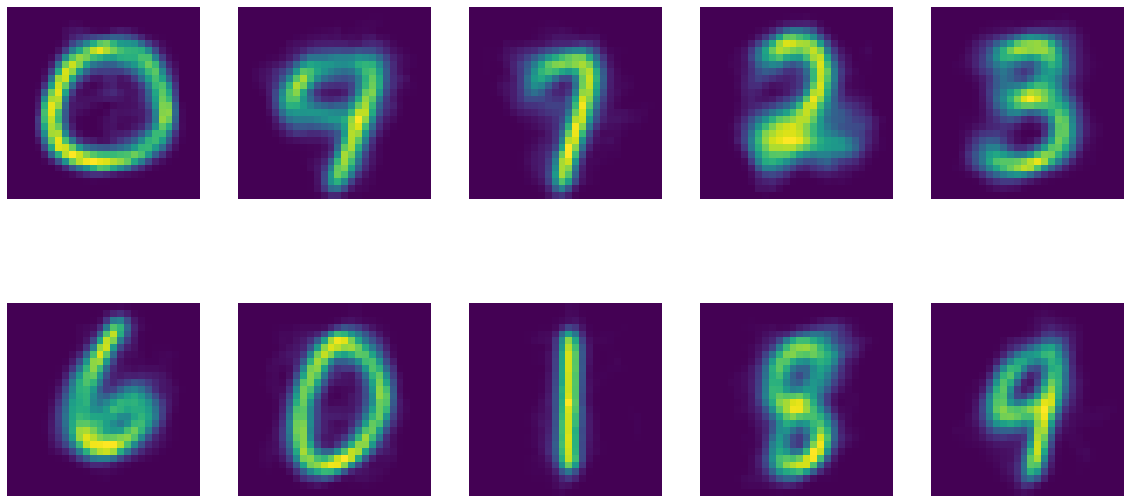

In [148]:
# Apply the clustering algorithm on the processed images
doCluster(X_proc, y_train)

Now, we clearly see that there is exactly one cluster for ones as expected, due to the rotation correction.

In [ ]:
# Use a 
# km = KernelKMeans(n_clusters=3,
#                       kernel="gak",
#                       kernel_params={"sigma": "auto"},
#                       n_init=20,
#                       verbose=True,
#                       random_state=408431)
# y_pred = km.fit_predict(X_train)
# print(score(y, y_pred))

## Exercise 2a
The unnormalized graph Laplacian is defined by $L = D - W$, where $W$ is the weight matrix such that $W_{ij} = K(x_i, x_j)$ and $D = \text{diag}(W)$.

In [223]:
# Compute the squared Euclidean distance matrix
# This is based on https://towardsdatascience.com/optimising-pairwise-euclidean-distance-calculations-using-python-fc020112c984
def sqDist(X):
    N = len(X)
    D = empty((N, N))
    for i in range(N):
        D[i, :] = ((X - X.loc[i])**2).sum(axis=1)

    return D


# Construct a graph Laplacian matrix L = D - W
def laplacian(X):
#     K = 10
#     N = len(X)
#     L = zeros((N, N), dtype=float32)
    
    # Compute the distance matrix
#     L = -euclidean_distances(X, X)
    L = -sqDist(X)
    
    return L

In [ ]:
t0 = time.time()
L = laplacian(X_train)
t = time.time() - t0

In [239]:
print('Computing the Laplacian costed {:.2f} s'.format(t))
print(L.shape)

Computing the Laplacian costed 0.12 s
(700, 700)


In [228]:
# Compute the K eigenvectors corresponding to the K smallest eigenvalues of L
t0 = time.time()
w, vecs = eigsh(L, K, sigma=0)      # Find K eigenvalues near zero using shift-invert mode
t = time.time() - t0

In [240]:
print('Finding the eigenvectors costed {:.2f} s'.format(t))
print(vecs.shape)

Finding the eigenvectors costed 0.12 s
(700, 10)


In [244]:
doCluster(vecs, y_train, False)

14:40:23 Starting K-means clustering using the metric 'sqeuclidean'
14:40:23 Starting K-means clustering using the metric 'correlation'
14:40:24 Starting K-means clustering using the metric 'gauss'
14:40:24 Results:
Algorithm 	Homogeneity Completeness   Accuracy   Time [s]
My K-Means 	     0.0336       0.0354       16.4%     0.172
My K-Means corr.     0.0000       1.0000       11.3%     0.083
My K-Means gauss.    0.0020       0.0069       11.7%     0.064
Exist. K-Means	     0.0430       0.0466       18.0%     0.067


## Exercise 2b | Self-made Function eigsh
